In [72]:
%load_ext autoreload
%autoreload 2
from pathlib import Path

import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

# construct_training_set = True
construct_training_set = False

# use_cloudaugment = True
use_cloudaugment = False

# create U-Net folder
unet_model_dir = Path("../cloud_seg/models/unet/")
unet_model_dir.mkdir(parents=True, exist_ok=True)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [155]:

import shutil
import numpy as np
import pandas as pd
import pandas_path as path
from PIL import Image
import torch
import pytorch_lightning as pl
import glob
from pathlib import Path
import argparse
import os
import datetime

from pytorch_lightning import loggers as pl_loggers
import albumentations as A

from cloud_seg.models.unet.cloud_model import CloudModel
from cloud_seg.utils.augmentations import CloudAugmentations

DATA_DIR = Path.cwd().parent.resolve() / "data/"
DATA_DIR_MODEL_TRAINING = DATA_DIR / "model_training/"
DATA_DIR_CLOUDLESS = DATA_DIR / 'cloudless/tif/'
DATA_DIR_CLOUDS = DATA_DIR / 'clouds/'

TRAIN_FEATURES = DATA_DIR / "train_features"
TRAIN_FEATURES_NEW = DATA_DIR / "train_features_new"

TRAIN_LABELS = DATA_DIR / "train_labels"


def none_or_str(value):
    if value == 'None':
        return None
    return value

parser = argparse.ArgumentParser(description='runtime parameters')

# Data and IO
parser.add_argument("--bands", nargs='+' , default=["B02", "B03", "B04", "B08"],
                    help="bands desired")

parser.add_argument("--bands_new", nargs='+', default=None,
                    help="additional bands to use beyond original four")

parser.add_argument("-cv", "--cross_validation_split", type=int, default=0,
                    help="cross validation split to use for training") 

parser.add_argument("--OUTPUT_DIR", type=str, default='../trained_models/',
                    help="Directory to save logs and trained models model")

parser.add_argument("--LOG_DIR", type=str, default='logs/',
                    help="Sub-directory of OUTPUT_DIR to save logs")

parser.add_argument("--MODEL_DIR", type=str, default='model/',
                    help="Sub-directory of OUTPUT_DIR to save logs")

parser.add_argument("--seed", type=int , default=13579,
                    help="random seed for train test split")

parser.add_argument("-v", "--verbose", action="store_true",
                    help="increase output verbosity")


# Training (gpus, optimization, etc...)
parser.add_argument("--gpu", action="store_true",
                    help="Use GPU")

parser.add_argument("--strategy", type=str, default='ddp',
                    help="Distributed training strategy")

parser.add_argument("--test_run", action="store_true",
                    help="Subsample training and validation data")

parser.add_argument("--test_run_nchips", type=int, default=512,
                    help="Subsample training and validation data to this size")

parser.add_argument("--num_workers", type=int, default=3,
                    help="number of data loader workers")

parser.add_argument("--persistent_workers", action="store_false",
                    help="Persistent data loader workers")

parser.add_argument("--batch_size", type=int, default=8,
                    help="Batch size for model training")

parser.add_argument("--loss_function", type=str, default='bce',
                    help="loss_function to use", choices=['bce', 'dice', 'jaccard'])

parser.add_argument("-lr", "--learning_rate", type=float, default=1e-3,
                    help="Learning rate for model optimization")

parser.add_argument("--optimizer", type=str, default='ADAM',
                    help="Optimizer to use", choices=['ADAM', 'SGD', 'ADAMW'])

parser.add_argument("--scheduler", type=str, default='plateau',
                    help="Learning rate scheduler to use", choices=['plateau', 'exponential', 'cosine'])

parser.add_argument("--plot_validation_images", action="store_false",
                    help="Plot final batch to tensorboard")

# Models and Augmentations
parser.add_argument("--segmentation_model", type=str, default='unet',
                    help="Encocoder architecture to use", choices=['unet', 'DeepLabV3Plus'])

parser.add_argument("--encoder_name", type=str, default='resnet18',
                    help="Encocoder architecture to use", choices=['efficientnet-b0','efficientnet-b3','efficientnet-b5',
                                                                   'resnet18', 'resnet34', 'resnet50',
                                                                   'vgg19_bn',
                                                                  'tu-efficientnetv2_m'])
parser.add_argument("--weights", type=none_or_str, default=None,
                    help="Pretrained_weights architecture to use")

parser.add_argument("--decoder_attention_type", type=none_or_str, default=None,
                    help="Attention in decoder")

parser.add_argument("--augmentations", type=str, default='vf',
                    help="training augmentations to use")

parser.add_argument("--cloud_augmentations", type=str, default='',
                    help="training augmentations to use for cloudmix")

parser.add_argument("--cloud_augment", action="store_true",
                    help="Use cloud augmentation")

parser.add_argument("--custom_feature_channels", type=str, default=None,
                    help="Use cloud augmentation", choices=['true_color', 'log_bands', 'ratios'])


args = parser.parse_args(args=[])

hparams = vars(args)
if hparams['verbose']: print("Parameters are: ", hparams)

pl.seed_everything(hparams['seed'], workers=True)
hparams['precision'] = 32
hparams['bands_use'] = sorted(hparams['bands'] + hparams['bands_new']) if hparams['bands_new'] is not None else hparams['bands']

# hparams['band_means'] = [band_mean_std[i]['mean'] for i in hparams['bands_use']]
# hparams['band_stds'] = [band_mean_std[i]['std'] for i in hparams['bands_use']]
# hparams['max_pixel_value'] = 1.0
# if hparams['custom_feature_channels'] == "true_color":
#     hparams['bands_use'] = ['B04', 'B03', 'B02']
#     hparams['band_means'] = [0.485, 0.456, 0.406] # imagenet for now
#     hparams['band_stds'] = [0.229, 0.224, 0.225]      
#     hparams['max_pixel_value'] = 255



Global seed set to 13579


In [156]:
hparams['cloud_augment'] = True

In [157]:
    
# Set up transforms using Albumentations library
Augs = CloudAugmentations(hparams)
train_transforms, train_transforms_names = Augs.add_augmentations()
train_transforms = A.Compose(train_transforms)

augs_val = 'nr' if 'Normalize' in train_transforms_names else ''
val_transforms, val_transforms_names = Augs.add_augmentations(augs_val)
val_transforms = A.Compose(val_transforms)

print("Train, val transforms: ", train_transforms_names, val_transforms_names)

cloud_transforms = None
if hparams['cloud_augment']:
    # Set up transforms using Albumentations library
    cloud_transforms, cloud_transforms_names = Augs.add_augmentations(hparams['cloud_augmentations'])
    cloud_transforms = A.Compose(cloud_transforms)
    print("cloud transforms: ", cloud_transforms_names)


Train, val transforms:  ['VerticalFlip'] []
cloud transforms:  []


In [158]:
val_x = pd.read_csv(DATA_DIR_MODEL_TRAINING / f"validate_features_meta_cv{hparams['cross_validation_split']}.csv")
val_y = pd.read_csv(DATA_DIR_MODEL_TRAINING / f"validate_labels_meta_cv{hparams['cross_validation_split']}.csv")

# shuffle validation, such that each batch will have samples from different locations,
# as validation_dataloader has shuffle=False
val_x = val_x.sample(frac=1, random_state=42).reset_index(drop=True)
val_y = val_y.sample(frac=1, random_state=42).reset_index(drop=True)

if hparams['verbose']: print(val_y.head())

train_x = pd.read_csv(DATA_DIR_MODEL_TRAINING / f"train_features_meta_cv{hparams['cross_validation_split']}.csv")
train_y = pd.read_csv(DATA_DIR_MODEL_TRAINING / f"train_labels_meta_cv{hparams['cross_validation_split']}.csv")

if not hparams['cloud_augment']:

    df_cloudbank = None

if hparams['cloud_augment']:

    nuse = 2

    train_x = train_x.iloc[:nuse]
    train_y = train_y.iloc[:nuse]

    val_x = val_x.iloc[:nuse]
    val_x = val_x.iloc[:nuse]

        
    train_x_cloudless = pd.read_csv(DATA_DIR_MODEL_TRAINING / f"train_features_cloudless_meta_cv{hparams['cross_validation_split']}.csv")
    train_y_cloudless = pd.read_csv(DATA_DIR_MODEL_TRAINING / f"train_labels_cloudless_meta_cv{hparams['cross_validation_split']}.csv")

    train_y = train_y.append(train_y_cloudless, ignore_index=True)
    train_x = train_x.append(train_x_cloudless, ignore_index=True)

    # train_x = pd.read_csv(DATA_DIR_MODEL_TRAINING / f"train_features_cloudless_meta_cv{hparams['cross_validation_split']}.csv")
    # train_y = pd.read_csv(DATA_DIR_MODEL_TRAINING / f"train_labels_cloudless_meta_cv{hparams['cross_validation_split']}.csv")

    df_cloudbank = pd.read_csv(DATA_DIR_MODEL_TRAINING / f"cloudbank_meta_cv{hparams['cross_validation_split']}.csv")

# Set up models and callbacks
cloud_model = CloudModel(
    bands=hparams['bands_use'],
    x_train=train_x,
    y_train=train_y,
    x_val=val_x,
    y_val=val_y,
    cloudbank=df_cloudbank,
    train_transforms=train_transforms,
    val_transforms=val_transforms,
    cloud_transforms=cloud_transforms,
    hparams=hparams,
)

In [159]:
train_y.head()

,chip_id,label_path
0,ajoi,/pscratch/sd/g/gstein/machine_learning/cloud-s...
1,ajph,/pscratch/sd/g/gstein/machine_learning/cloud-s...
2,ajwp_nc_6,cloudless
3,dbkx_nc_1,cloudless
4,kvab_nc_2,cloudless


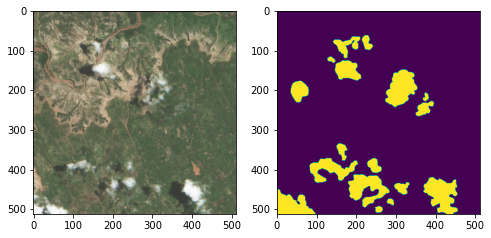

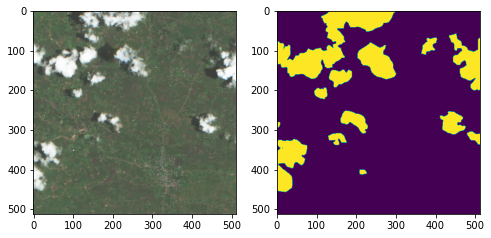

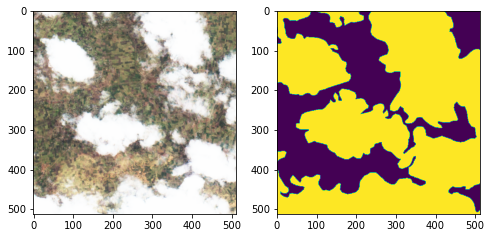

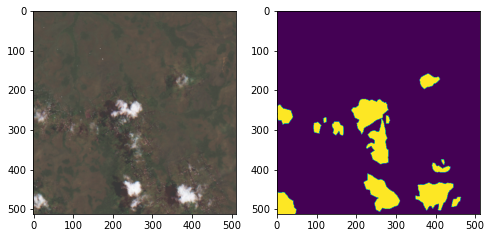

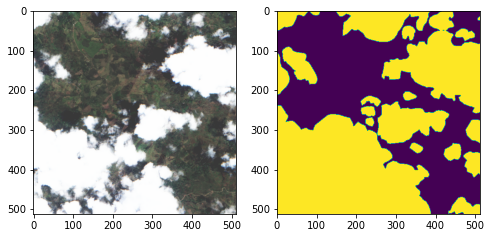

In [162]:
import matplotlib.pyplot as plt

def true_color_band(band_data, nodata=1, pixel_max=255, c=10., th=0.125):
    """
    Normalize band with:    
    min_val = np.nanmin(data)
    max_val = np.nanmax(data)
    range_val = max_val - min_val
    
    out = (data.astype(np.float32) - min_val)/range_val
    out = 1. / (1. + np.exp(c * (th - out)))
    
    Copied from https://xarray-spatial.org/_modules/xrspatial/multispectral.html#true_color
    """
    # a = np.where(np.logical_or(np.isnan(r), r <= nodata), 0, 255)
    pixel_max = 255

    # h, w = band_data.shape
    # out = np.zeros((h, w, 4), dtype=np.uint8)
    # out[:, :, 0] = (normalize_data_numpy(r, pixel_max, c, th)).astype(np.uint8)
    # out[:, :, 1] = (normalize_data_numpy(g, pixel_max, c, th)).astype(np.uint8)
    # out[:, :, 2] = (normalize_data_numpy(b, pixel_max, c, th)).astype(np.uint8)
    
    out = normalize_data_xrspatial(band_data, pixel_max, c, th) #).astype(np.uint8)

    return out

def normalize_data_xrspatial(data, pixel_max, c, th):
    """
    Copied from https://xarray-spatial.org/_modules/xrspatial/multispectral.html#true_color
    """
    # min_val = np.nanmin(data)
    # max_val = np.nanmax(data)
    min_val = 0
    max_val = 10000
    data = np.clip(data, min_val, max_val)
    
    range_val = max_val - min_val
    out = (data.astype(np.float32) - min_val)/range_val
    out = 1. / (1. + np.exp(c * (th - out)))
    
    return out * pixel_max


istart = 0
nplt = 5
for iplt in range(istart, istart+nplt):
    item = cloud_model.train_dataset.__getitem__(iplt)
    im = item['chip']
    label = item['label']

    r = true_color_band(im[2])
    g = true_color_band(im[1])
    b = true_color_band(im[0])

    im = np.stack([r,g,b], axis=-1).astype(np.uint8)

    fig, ax = plt.subplots(1,2,figsize=(8,4))
    ax[0].imshow(im)
    ax[1].imshow(label, vmin=0, vmax=1)